#### **INSTALL LIBRARIES FOR THE PROJECT**

In [1]:
# Install PyTorch (if not already installed)
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

# Install other required packages
!pip install opencv-python matplotlib

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


#### **CLONE DETECTRON2 REPO AND INSTALL IN NOTEBOOK**

In [2]:
# Clone the repository
!git clone https://github.com/facebookresearch/detectron2.git
%cd detectron2

# Install Detectron2
!pip install -e .

Cloning into 'detectron2'...
remote: Enumerating objects: 15792, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 15792 (delta 15), reused 27 (delta 10), pack-reused 15743 (from 1)
Receiving objects: 100% (15792/15792), 6.37 MiB | 21.12 MiB/s, done.
Resolving deltas: 100% (11507/11507), done.
/kaggle/working/detectron2
Obtaining file:///kaggle/working/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42

#### **IMPORT COMMON LIBRARIES AND DETECTRON2 UTILITIES**

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

#### **REGISTER CUSTOM DATSET ON DETECTRON2**

In [4]:
from detectron2.data.datasets import register_coco_instances
# Register the datasets
register_coco_instances("my_dataset_train", {}, "/kaggle/input/traffic-object-recognition/train/_annotations.coco.json", "/kaggle/input/traffic-object-recognition/train")
register_coco_instances("my_dataset_val", {}, "/kaggle/input/traffic-object-recognition/valid/_annotations.coco.json", "/kaggle/input/traffic-object-recognition/valid")
register_coco_instances("my_dataset_test", {}, "/kaggle/input/traffic-object-recognition/test/_annotations.coco.json", "/kaggle/input/traffic-object-recognition/test")

#### **VISUALIZE TRAINING DATA**

WARNING [10/25 14:18:39 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/25 14:18:39 d2.data.datasets.coco]: Loaded 494 images in COCO format from /kaggle/input/traffic-object-recognition/train/_annotations.coco.json


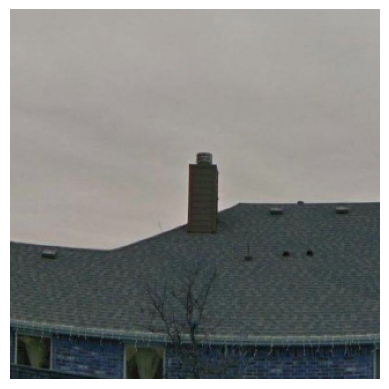

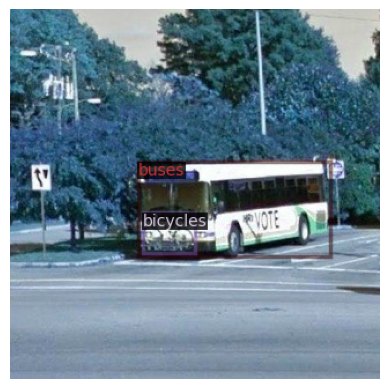

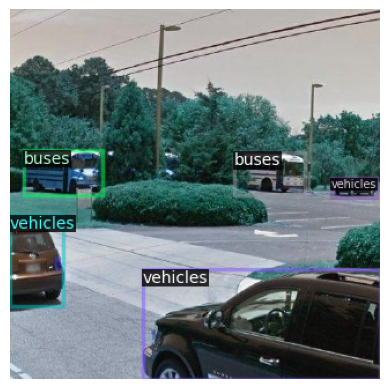

In [5]:
import cv2
import random
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer

#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    
    # Your existing visualization code
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)

    # Display using matplotlib
    plt.imshow(vis.get_image()[:, :, ::-1])  # Convert BGR to RGB
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()    

#### **CONFIGURE DETECTRON2 FOR TRAINING OUR FAST R-CNN MODEL WITH RESNET-101 BACKBONE**

In [6]:
# Initialize configuration
cfg = get_cfg()
# load a configuration file with ResNet-based architecture, specifically ResNeXt-101 32x8d (denoted by the "faster_rcnn_X_101_32x8d_FPN_3x.yaml" model)
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))

# Specify Datasets for Training and Validation
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)


# Sets the number of CPU threads for data loading to 4, allowing faster data loading
cfg.DATALOADER.NUM_WORKERS = 4
# Load pre-trained weights from the ResNet-101 backbone 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
#  Set the batch size to 4 images per iteration
cfg.SOLVER.IMS_PER_BATCH = 4
# Set the initial learning rate to 0.001
cfg.SOLVER.BASE_LR = 0.001

# Increase learning rate gradually for the first 1000 iterations to stabilize initial training
cfg.SOLVER.WARMUP_ITERS = 1000
# Set the total number of training iterations to 1500
cfg.SOLVER.MAX_ITER = 1500 
# Reduce the learning rate during training (at iterations 1000 and 1400)
cfg.SOLVER.STEPS = (1000, 1400)
# Reduce the learning rate by a factor of 0.05 at each step (for better model covergence) 
cfg.SOLVER.GAMMA = 0.05

# Set the number of proposals to sample per image  
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
# Sets the number of object classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 12
# Evaluate the model every 500 iterations to monitor performance 
cfg.TEST.EVAL_PERIOD = 500

#### **DEFINE CUSTOM TRAINER CLASS(COCO TRAINER) TO TRAIN OUR MODEL USING COC0EVALUATOR**

In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

#### **CHECK IF CONNECTED TO GPU**

In [8]:
import torch
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


#### **TRAIN OUR MODEL**

In [9]:
# Create a trainer instance to manage setup and execution of the training loop
trainer = DefaultTrainer(cfg)
# Load weights or start training
trainer.resume_or_load(resume=False) 
# Start training
trainer.train()  

[10/25 14:19:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:11, 38.0MB/s]                              


[10/25 14:19:16 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/25 14:20:12 d2.utils.events]:  eta: 1:05:23  iter: 19  total_loss: 3.545  loss_cls: 2.532  loss_box_reg: 0.9303  loss_rpn_cls: 0.05424  loss_rpn_loc: 0.02127    time: 2.6547  last_time: 2.4763  data_time: 0.0189  last_data_time: 0.0095   lr: 1.931e-06  max_mem: 6901M
[10/25 14:21:21 d2.utils.events]:  eta: 1:05:57  iter: 39  total_loss: 3.589  loss_cls: 2.485  loss_box_reg: 0.9336  loss_rpn_cls: 0.1542  loss_rpn_loc: 0.02591    time: 2.7279  last_time: 2.3037  data_time: 0.0101  last_data_time: 0.0102   lr: 2.911e-06  max_mem: 6901M
[10/25 14:22:18 d2.utils.events]:  eta: 1:07:24  iter: 59  total_loss: 3.433  loss_cls: 2.432  loss_box_reg: 0.9084  loss_rpn_cls: 0.07636  loss_rpn_loc: 0.02858    time: 2.7807  last_time: 3.0768  data_time: 0.0100  last_data_time: 0.0113   lr: 3.891e-06  max_mem: 6901M
[10/25 14:23:14 d2.utils.events]:  eta: 1:06:09  iter: 79  total_loss: 3.408  loss_cls: 2.351  loss_box_reg: 0.9814  loss_rpn_cls: 0.03219  loss_rpn_loc: 0.01478    time: 2.7823  last_t

#### **EVALUATE THE TRAINED MODEL ON TEST DATASET**

In [10]:
import os
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# Load model weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# Set confidence threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75
# Set up evaluator
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
# Build test data loader which will feed images into the model for evaluation
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
# Run evaluation
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [10/25 15:32:10 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [10/25 15:32:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/25 15:32:10 d2.data.datasets.coco]: Loaded 133 images in COCO format from /kaggle/input/traffic-object-recognition/test/_annotations.coco.json
[10/25 15:32:10 d2.data.build]: Distribution of instances among all 8 categories:
|   category    | #instances   |   category    | #instances   |  category   | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-----------:|:-------------|
| road-traffic  | 0            |   bicycles    | 22           |    buses    | 12           |
|  crosswalks   | 81           | fire hydrants | 23           | motorcycles | 30           |
| traffic lig.. | 129          |   vehicles    | 209          |             |              

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[10/25 15:32:12 d2.evaluation.evaluator]: Inference done 11/133. Dataloading: 0.0013 s/iter. Inference: 0.1858 s/iter. Eval: 0.0004 s/iter. Total: 0.1875 s/iter. ETA=0:00:22
[10/25 15:32:17 d2.evaluation.evaluator]: Inference done 38/133. Dataloading: 0.0015 s/iter. Inference: 0.1862 s/iter. Eval: 0.0003 s/iter. Total: 0.1882 s/iter. ETA=0:00:17
[10/25 15:32:22 d2.evaluation.evaluator]: Inference done 65/133. Dataloading: 0.0016 s/iter. Inference: 0.1871 s/iter. Eval: 0.0003 s/iter. Total: 0.1891 s/iter. ETA=0:00:12
[10/25 15:32:27 d2.evaluation.evaluator]: Inference done 92/133. Dataloading: 0.0016 s/iter. Inference: 0.1881 s/iter. Eval: 0.0003 s/iter. Total: 0.1901 s/iter. ETA=0:00:07
[10/25 15:32:32 d2.evaluation.evaluator]: Inference done 118/133. Dataloading: 0.0016 s/iter. Inference: 0.1890 s/iter. Eval: 0.0003 s/iter. Total: 0.1911 s/iter. ETA=0:00:02


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[10/25 15:32:35 d2.evaluation.evaluator]: Total inference time: 0:00:24.567131 (0.191931 s / iter per device, on 1 devices)
[10/25 15:32:35 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:24 (0.189536 s / iter per device, on 1 devices)
[10/25 15:32:35 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/25 15:32:35 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[10/25 15:32:35 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[10/25 15:32:36 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[10/25 15:32:36 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.07 seconds.
[10/25 15:32:36 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[10/25 15:32:36 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.03 seconds.
 Average Precision  (AP)

OrderedDict([('bbox',
              {'AP': 44.19202396670149,
               'AP50': 76.8684180038807,
               'AP75': 43.913712385467456,
               'APs': 18.22136338418873,
               'APm': 35.77694649072332,
               'APl': 53.12961874440473,
               'AP-road-traffic': nan,
               'AP-bicycles': 42.67913245508943,
               'AP-buses': 54.8021659308788,
               'AP-crosswalks': 12.914846221314203,
               'AP-fire hydrants': 59.276249823294854,
               'AP-motorcycles': 45.328802355655505,
               'AP-traffic lights': 44.37614604079052,
               'AP-vehicles': 49.96682493988711})])

#### **LOAD IMAGE FROM TEST DATASET, MAKE PREDICTIONS ON THE IMAGE AND VISUALIZE THE PREDICTED RESULTS**

[10/25 15:33:45 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/opt/conda/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

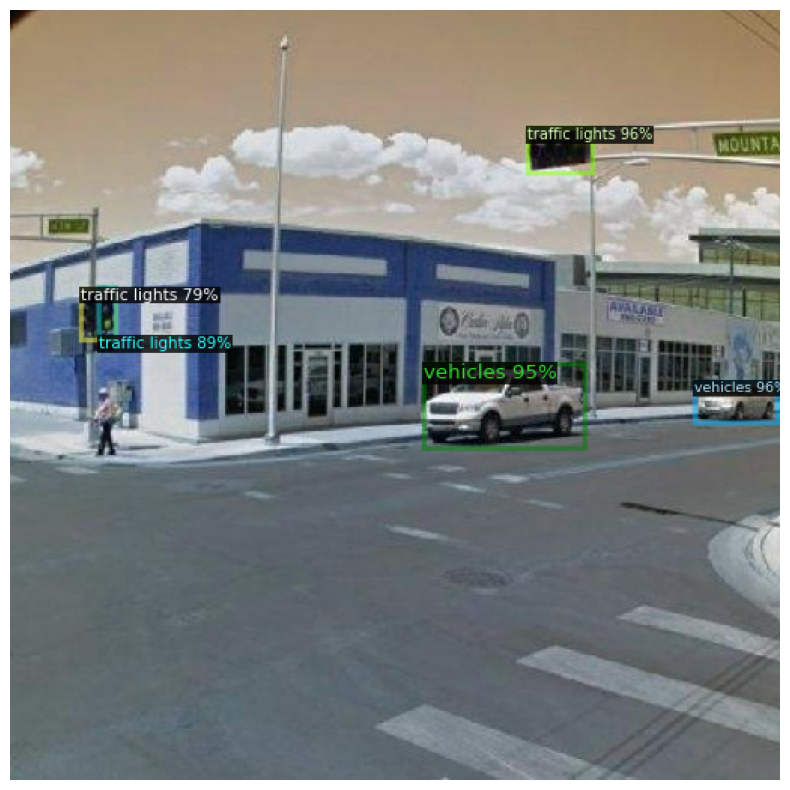

In [12]:
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
import cv2
import glob

# Define or access the test metadata
test_metadata = MetadataCatalog.get("my_dataset_test")
# Create predictor
predictor = DefaultPredictor(cfg)

# Loop through test images
for imageName in glob.glob('/kaggle/input/traffic-object-recognition/test/1653385923735_jpg.rf.caad53fe93179609c068a7adf45b3b0c.jpg'):
    im = cv2.imread(imageName)  # Read the image
    outputs = predictor(im)  # Get predictions
    
    # Visualize the output
    v = Visualizer(im[:, :, ::-1],  # Convert BGR to RGB for visualization
                   metadata=test_metadata, 
                   scale=0.8)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Prepare the image for display with matplotlib
    output_image = out.get_image()[:, :, ::-1]  # Convert back to RGB for matplotlib

    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))  # Set figure size
    plt.imshow(output_image)  # Display the image
    plt.axis('off')  # Turn off axis labels
    plt.show()  # Render the image


#### **VISUALIZE LOSS VALUES OVER EACH ITERATION**

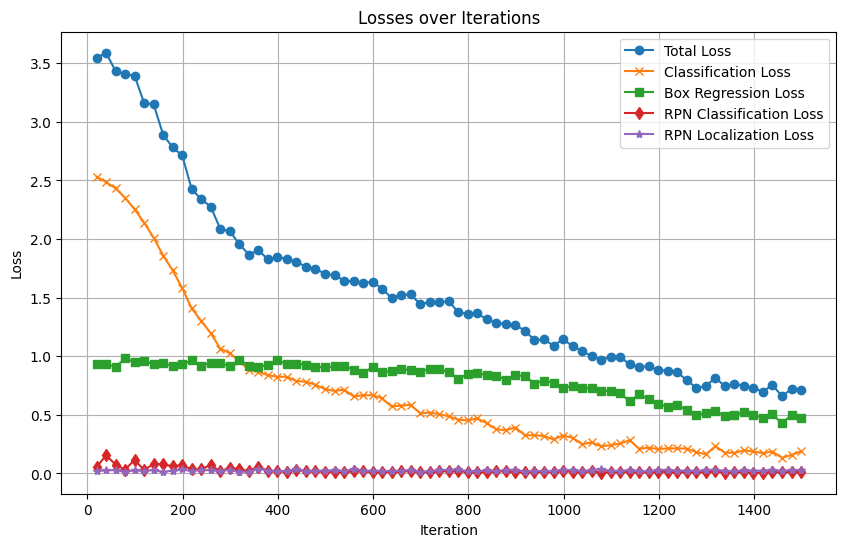

In [13]:
import json

# Path to your metrics.json file
log_path = './output/metrics.json'

# Initialize lists to store values
iterations = []
total_loss = []
loss_cls = []
loss_box_reg = []
loss_rpn_cls = []
loss_rpn_loc = []

# Parse the json file
with open(log_path, 'r') as f:
    for line in f:
        data = json.loads(line)
        if 'total_loss' in data:
            iterations.append(data['iteration'])
            total_loss.append(data['total_loss'])
            if 'loss_cls' in data:
                loss_cls.append(data['loss_cls'])
            if 'loss_box_reg' in data:
                loss_box_reg.append(data['loss_box_reg'])
            if 'loss_rpn_cls' in data:
                loss_rpn_cls.append(data['loss_rpn_cls'])
            if 'loss_rpn_loc' in data:
                loss_rpn_loc.append(data['loss_rpn_loc'])

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(iterations, total_loss, label="Total Loss", marker='o')
plt.plot(iterations, loss_cls, label="Classification Loss", marker='x')
plt.plot(iterations, loss_box_reg, label="Box Regression Loss", marker='s')
plt.plot(iterations, loss_rpn_cls, label="RPN Classification Loss", marker='d')
plt.plot(iterations, loss_rpn_loc, label="RPN Localization Loss", marker='*')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Losses over Iterations")
plt.legend()
plt.grid(True)
plt.show()


#### **VISUALIZE AVERAGE PRECISION ACCROSS EACH CATEGORY(CLASS)**

[10/25 18:45:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/detectron2/output/model_final.pth ...


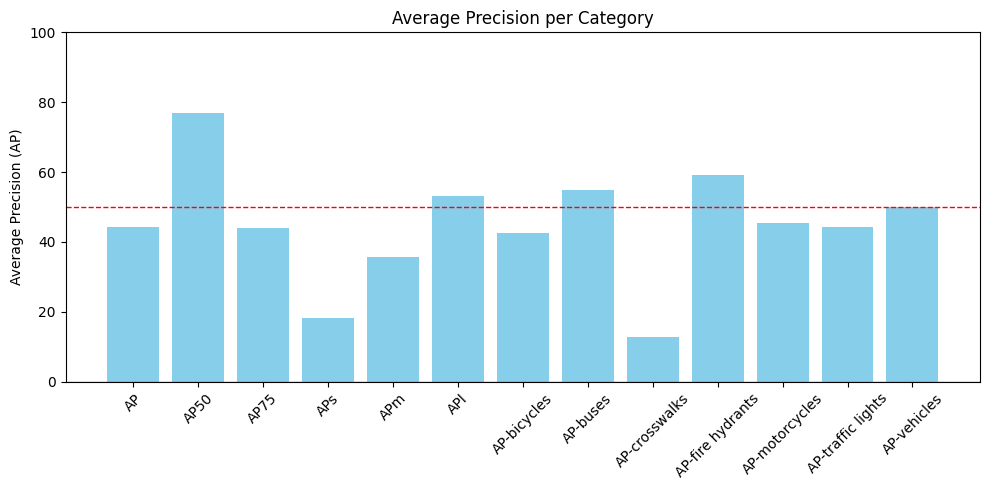

In [93]:
import torch
from math import isnan  # Import isnan to check for NaN values


def plot_average_precision(average_precision):
    categories = list(average_precision.keys())
    ap_values = list(average_precision.values())

    plt.figure(figsize=(10, 5))
    plt.bar(categories, ap_values, color='skyblue')
    plt.ylabel('Average Precision (AP)')
    plt.title('Average Precision per Category')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)  # Assuming AP is between 0 and 100
    plt.axhline(0, color='grey', lw=1)
    plt.axhline(50, color='red', linestyle='--', lw=1)  # set threshold of 50
    plt.tight_layout()
    plt.savefig('average_precision.png')
    plt.show()

# Average Precision 
average_precision = {
    'AP': 44.192,
    'AP50': 76.868,
    'AP75': 43.914,
    'APs': 18.221,
    'APm': 35.777,
    'APl': 53.130,
    'AP-road-traffic': float('nan'),
    'AP-bicycles': 42.679,
    'AP-buses': 54.802,
    'AP-crosswalks': 12.915,
    'AP-fire hydrants': 59.276,
    'AP-motorcycles': 45.329,
    'AP-traffic lights': 44.376,
    'AP-vehicles': 49.967
}

# Filter out nan values for plotting
average_precision_filtered = {k: v for k, v in average_precision.items() if not isinstance(v, float) or not isnan(v)}

# Plot average precision
plot_average_precision(average_precision_filtered)
